In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_dataset(): 
    sales = pd.read_excel("sales.xlsx",header =1)
    view_rate = pd.read_excel("view_rate.xlsx",header =1, index_col= 0)
    test = pd.read_excel('test.xlsx',header=1)
    return sales, view_rate, test

sales = load_dataset()[0]
view_rate = load_dataset()[1]
test = load_dataset()[2]

In [3]:
sales_origine =sales.copy()
rating_origine = view_rate.copy()
test_origine = test.copy()

#print( sales.head(), sales.info() )
# sales =  pd.DataFrame(sales_origine)
# view_rate =  pd.DataFrame(rating_origine)
# test =  pd.DataFrame(test_origine)

In [4]:
# 판매단가 > 취급액 이면 취급액 = 0 

def custom(price, total):
    if price > total:
        return 0
    
    else:
        return total

sales["취급액"] = sales.apply(lambda x : custom(x["판매단가"], x["취급액"]), axis=1)

# 확인
# print(sum((sales["판매단가"] > sales["취급액"]) & (sales['취급액'] != 0)))
# sales
# sales.reindex( list(range(len(sales))))

In [5]:
# columne 이름 바꾸기
columnname = { '방송일시' : 's_date', '노출(분)':'during', '마더코드':'mcode', '상품코드':'code','상품명':'name',
          '상품군':'category', '판매단가':'price', '취급액':'sum'}
sales.rename( columns = columnname, inplace = True)
test.rename( columns = columnname, inplace = True)

#sales.head()
#sales.loc[:,'category']

In [6]:
# 결측된 노출분 채우기

for i,row in sales.iterrows():
    val = row["during"]
    if i == 0 :
        continue
        
    if  np.isnan(val):
        if sales.loc[i,"s_date"] == sales.loc[i-1,"s_date"]:
            sales.loc[i,"during"] = sales.loc[i-1,"during"]
        else : 
            continue

            
for i,row in test.iterrows():
    val = row["during"]
    if i == 0 :
        continue
        
    if  np.isnan(val):
        if test.loc[i,"s_date"] == test.loc[i-1,"s_date"]:
            test.loc[i,"during"] = test.loc[i-1,"during"]
        else : 
            continue
            
print(sales.isnull().sum(), test.isnull().sum() )



s_date        0
during        0
mcode         0
code          0
name          0
category      0
price         0
sum         937
dtype: int64 s_date         0
during         0
mcode          0
code           0
name           0
category       0
price          0
sum         2891
dtype: int64


In [7]:
# 무형 Drop
sales.drop(sales[sales["category"]=="무형"].index, inplace=True)
test.drop(test[test["category"]=="무형"].index, inplace=True)

# 판매단가보다 취급액이 적은 경우 Drop
# sales.drop(sales[sales["판매단가"]>=sales["취급액"]].index, inplace = True)

In [8]:
# 마지막 열의 값이 mena일까? 
# test_lst= np.round(np.mean(view_rate.iloc[:,:-1].values,axis=1),3)==view_rate.iloc[:,-1].values
# print(test_lst.all())
# for i in np.argwhere(test_lst ==False):
#     print("{}번째 열들의 평균은 ".format(i))
#     print("마지막 열 직전까지의 값 {}".format(np.mean(view_rate.iloc[i,:-1].values)))
#     print("실제값 : {}\n".format(view_rate.iloc[i,-1].values))

해당 위치에서 mean 값이랑 값이 맞지 않습니다.

In [9]:
# 마지막 열의 값이 mena일까? 
# test_lst= np.round(np.mean(view_rate.iloc[:-1,:].values,axis=0),3)==view_rate.iloc[-1,:].values
# print(test_lst.all())
# for i in np.argwhere(test_lst ==False):
#     print("{}번째 열들의 평균은 ".format(i))
#     print("마지막 열 직전까지의 값 {}".format(np.mean(view_rate.iloc[:-1,i].values)))
#     print("실제값 : {}\n".format(view_rate.iloc[-1,i].values[0]))

In [10]:
# 판매개수 계산
sales['count'] = sales['sum'] / sales['price']
test['count'] = test['sum'] / test['price']

# 판매시간 구분
sales['month'] = sales['s_date'].dt.month
sales['day'] = sales['s_date'].dt.day

test['month'] = test['s_date'].dt.month
test['day'] = test['s_date'].dt.day

sales['during'] = sales['during'].apply(lambda x: datetime.timedelta(minutes=x))  # 한번만 하면 된다.
test['during'] = test['during'].apply(lambda x: datetime.timedelta(minutes=x))

sales['e_time'] = sales['s_date'] + sales['during']
test['e_time'] = test['s_date'] + test['during']
sales['e_time'] = sales['e_time'].dt.time

sales['weekday'] = sales['s_date'].dt.weekday
test['weekday'] = test['s_date'].dt.weekday

def sex(string):
    if '남성' in string:
        dummy = 0
    elif '여성' in string:
        dummy = 1
    else:
        dummy = 2
    
    return dummy

sales['sex'] = sales['name'].apply(sex)
test['sex'] = test['name'].apply(sex)

# for i in range(len(sales)):
#     if sales.loc[i,'category'] == '주방':
#         sales.loc[i,'sex'] = 1

# print(sales.head(), test.head())

#sales.dtypes

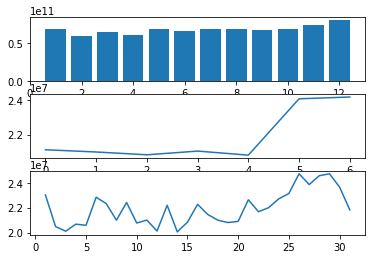

In [25]:
# 간단한 트렌드 확인

sales.groupby('sex').count()   # 남성 2583행, 여성 1688행, 미분류 33101행
monthly = pd.DataFrame(sales.groupby('month').sum()['sum'])   # 월별 총 매출액 합계
weekly = pd.DataFrame(sales.groupby('weekday').mean()['sum'])   # 요일별 평균 매출액
daily = pd.DataFrame(sales.groupby('day').mean()['sum'])   # 일별 평균 매출액

fig, axes = plt.subplots(3,1)
axes[0].bar(monthly.index,monthly['sum'])
axes[1].plot(weekly.index,weekly['sum'])
axes[2].plot(daily.index,daily['sum'])

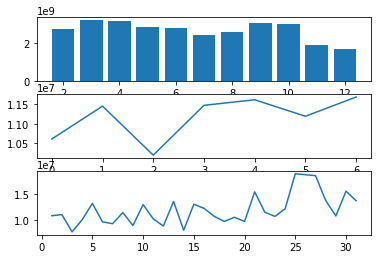

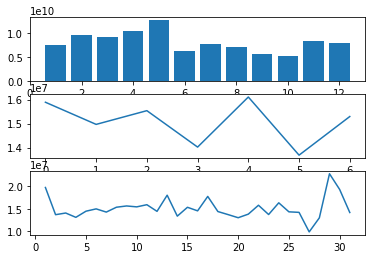

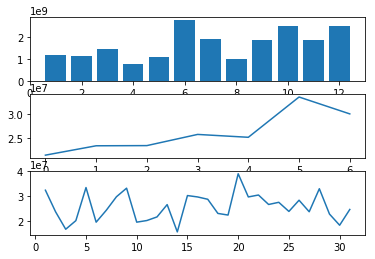

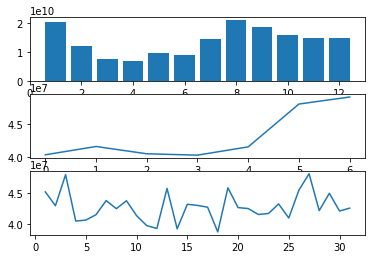

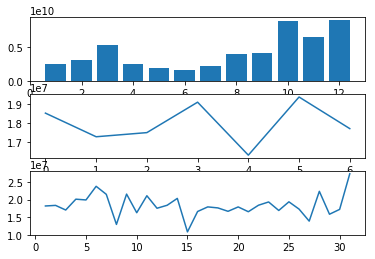

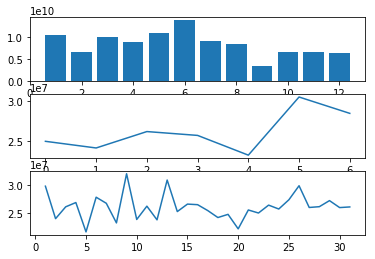

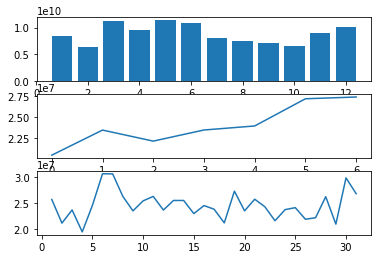

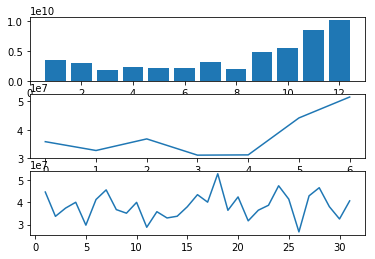

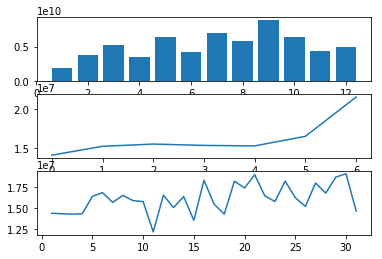

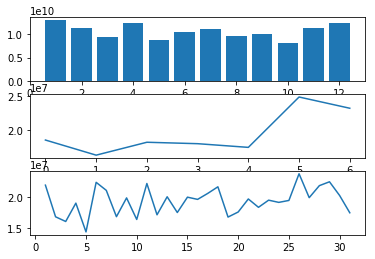

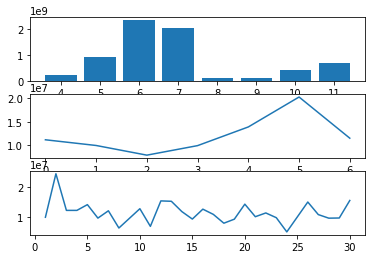

In [28]:
def eda(table):
    monthly = pd.DataFrame(table.groupby('month').sum()['sum'])   # 월별 총 매출액 합계
    weekly = pd.DataFrame(table.groupby('weekday').mean()['sum'])   # 요일별 평균 매출액
    daily = pd.DataFrame(table.groupby('day').mean()['sum'])   # 일별 평균 매출액

    fig, axes = plt.subplots(3,1)
    axes[0].bar(monthly.index,monthly['sum'])
    axes[1].plot(weekly.index,weekly['sum'])
    axes[2].plot(daily.index,daily['sum'])
    return fig, axes

for i in range(0,11):
    eda(sales_ca[i])

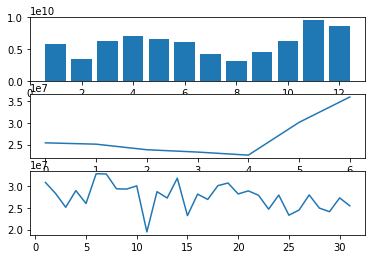

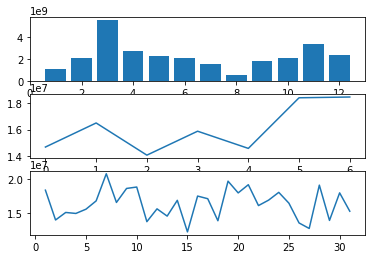

In [26]:
# 총매출액, 요일별 평균 매출액, 일별 평균 매출액에 성차가 있는지 확인

msales = sales[sales['sex'] == 0]
fsales = sales[sales['sex'] == 1]

# male 에 대해서
mmonthly = pd.DataFrame(msales.groupby('month').sum()['sum'])   # 월별 총 매출액 합계
mweekly = pd.DataFrame(msales.groupby('weekday').mean()['sum'])   # 요일별 평균 매출액
mdaily = pd.DataFrame(msales.groupby('day').mean()['sum'])   # 일별 평균 매출액

fig, axes = plt.subplots(3,1)
axes[0].bar(mmonthly.index,mmonthly['sum'])
axes[1].plot(mweekly.index,mweekly['sum'])
axes[2].plot(mdaily.index,mdaily['sum'])

# female
fmonthly = pd.DataFrame(fsales.groupby('month').sum()['sum'])   # 월별 총 매출액 합계
fweekly = pd.DataFrame(fsales.groupby('weekday').mean()['sum'])   # 요일별 평균 매출액
fdaily = pd.DataFrame(fsales.groupby('day').mean()['sum'])   # 일별 평균 매출액

fig, axes = plt.subplots(3,1)
axes[0].bar(fmonthly.index,fmonthly['sum'])
axes[1].plot(fweekly.index,fweekly['sum'])
axes[2].plot(fdaily.index,fdaily['sum'])

In [14]:
category_num = {
    '가구' : 0, '가전':1, '건강기능':2, '농수축':3, '생활용품':4, '속옷':5, '의류':6, '이미용':7, '잡화':8, '주방':9, 
'침구':10}
num_category = {
    0 : '가구', 1:'가전', 2:'건강기능', 3:'농수축', 4:'생활용품', 5:'속옷', 6:'의류', 7:'이미용', 8:'잡화', 9:'주방',
    10:'침구'
}

sales_ca = []
test_ca = []

for i in range(0,11):
    arr = test[test['category'] == '{}'.format(num_category[i])].copy()
    test_ca.append( arr )
    
for i in range(0,11):
    arr = sales[sales['category'] == '{}'.format(num_category[i])].copy()
    sales_ca.append( arr )

In [15]:
# 테스트셋과 트레인셋 간의 데이터 유사도 확인

# name_set = set( sales['name'] )
# t_name_set = set( test['name'])

# code_set = set( sales['code'])
# t_code_set = set( test['code'])

# mcode_set = set( sales['mcode'])
# t_mcode_set = set( test['mcode'])

# category_set = set( sales['category'])
# t_category_set = set( test['category'])

# print("{} - {} = {} : 새로운 상품명".format(len(t_name_set),len(name_set),len(t_name_set - name_set)))
# print("{} - {} = {} : 새로운 상품코드".format(len(t_code_set),len(code_set),len(t_code_set - code_set)))
# print("{} - {} = {} : 새로운 마더코드".format(len(t_mcode_set),len(mcode_set),len(t_mcode_set - mcode_set)))
# print("{} - {} = {} : 새로운 카테고리".format(len(t_category_set),len(category_set),len(t_category_set - category_set)))


# weekly_ca0 = pd.DataFrame(fsales.groupby('weekday').mean()['sum'])   # 요일별 평균 매출액
# daily_ca0 = pd.DataFrame(fsales.groupby('day').mean()['sum'])   # 일별 평균 매출액

# fig, axes = plt.subplots(2,1)
# axes[0].plot(fweekly.index,fweekly['sum'])
# axes[1].plot(fdaily.index,fdaily['sum'])

In [17]:
from konlpy.corpus import kolaw
from konlpy.tag import *

okt = Okt()
hannanum = Hannanum()

# 상품명 리스트로 받기

def tonouns(table):
    name_list = []

    for i,row in table.iterrows():
        name_list.append(row['name'].split(" "))
    
    name_one = [one for one in name_list if len(one) == 1]
    name_two = [one for one in name_list if len(one) != 1]
    name_nouns = [okt.nouns(str(noun)) for noun in name_one]
    
    name_prime = sum(name_nouns + name_two, [])
    
    return name_prime

# 리스트로 받은 상품명, 딕셔너리로 인덱싱

sales_nouns_dict = {}
test_nouns_dict = {}

for i in range(0,11):
    sales_nouns_dict['{}'.format(i)] = tonouns(sales_ca[i])
    test_nouns_dict['{}'.format(i)] = tonouns(test_ca[i])


In [ ]:
# 한글세팅

# from matplotlib import font_manager, rc

# font_name = font_manager.FontProperties(
#     fname="c:/Windows/Fonts/malgun.ttf").get_name()

# rc('font', family=font_name)

#from nltk import Text

# kolaw = Text(name_prime, name='kolaw')
# kolaw.plot(10)
# plt.show()

In [ ]:
# test set 에서 새로운 이름이 등장하는 비율

# def ratio(sales,test):
#     return (len(set(test['name'])-set(sales['name'])))/len(set(test['name']))

# reasonable = []
# for i in range(len(set(sales['category']))):
#     ratio_ = ratio(sales_dict['{}'.format(i)],test_dict['{}'.format(i)])
#     reasonable.append(ratio_)
    
# test set 에서 새로운 명사가 등장하는 비율
    
# def ratio2(sales,test):
#     return (len(set(test)-set(sales)))/len(set(test))

# reasonable2 = []
# for i in range(len(set(sales['category']))):
#     ratio_ = ratio2(sales_nouns_dict['{}'.format(i)],test_nouns_dict['{}'.format(i)])
#     reasonable2.append(ratio_)
    
# print( reasonable, reasonable2)

In [18]:
# 명사 등장 횟수 세기

def nouns_count(seri):
    count={}
    for i in seri:
        try: count[i] += 1
        except: count[i]=1
    return count

count_list_test = []
count_list_sales = []

for i in range(0,11):
    count_list_test.append( nouns_count(test_nouns_dict['{}'.format(i)]) )
    count_list_sales.append( nouns_count(sales_nouns_dict['{}'.format(i)]) )

    
# 등장 횟수 기준으로 정렬

sorted_test = []
sorted_sales = []

for i in range(0,11):
    sorted_test.append( sorted(count_list_test[int('{}'.format(i))], key=lambda x : count_list_test[int('{}'.format(i))][x], reverse = True) )
    sorted_sales.append( sorted(count_list_sales[int('{}'.format(i))], key=lambda x : count_list_sales[int('{}'.format(i))][x], reverse = True) )


# 등장횟수 순위별로 데이터 프레임화

df_test = pd.DataFrame(sorted_test)
df_test = pd.DataFrame.transpose(df_test)
df_sales = pd.DataFrame(sorted_sales)
df_sales = pd.DataFrame.transpose(df_sales)


df_sales.rename( columns = num_category, inplace = True)
df_test.rename( columns = num_category, inplace = True)



In [19]:
# 상품명 카테고리별 하나의 리스트로 묶기(중복허용)

" ".join(test_nouns_dict['1'])

sales_tfidf = []
test_tfidf = []

for i in range(len(set(sales['category']))):
    sales_tfidf.append(" ".join(sales_nouns_dict['{}'.format(i)]))
    test_tfidf.append(" ".join(test_nouns_dict['{}'.format(i)]))

# TF-IDF 라이브러리를 이용한 상품명 벡터화

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_test = TfidfVectorizer().fit(test_tfidf)
tfidf_sales = TfidfVectorizer().fit(sales_tfidf)
tfidf_test.transform(test_tfidf).toarray()
tfidf_sales.transform(sales_tfidf).toarray()

# 벡터에 단어 이름 붙여주기

colname_test = {}
colname_sales = {}

for key in tfidf_test.vocabulary_:
    colname_test[tfidf_test.vocabulary_[key]] = key
    
for key in tfidf_sales.vocabulary_:
    colname_sales[tfidf_sales.vocabulary_[key]] = key

test_tfidf_arr = pd.DataFrame(tfidf_test.transform(test_tfidf).toarray())
test_tfidf_arr.rename( columns = colname_test, inplace = True)

sales_tfidf_arr = pd.DataFrame(tfidf_sales.transform(sales_tfidf).toarray())
sales_tfidf_arr.rename( columns = colname_sales, inplace = True)

test_tfidf_arr = pd.DataFrame.transpose(test_tfidf_arr)
sales_tfidf_arr = pd.DataFrame.transpose(sales_tfidf_arr)

def tfidf_sort(df):
    dd = dict( df[df > 0] )
    dd = sorted(dd, key = lambda x : dd[x], reverse = True)
    return dd

tfidf_t = []
tfidf_s = []

for i in range(0,11):
    tfidf_t.append(tfidf_sort(test_tfidf_arr[i]))
    tfidf_s.append(tfidf_sort(sales_tfidf_arr[i]))
    
tfidf_t = pd.DataFrame(tfidf_t)
tfidf_t = pd.DataFrame.transpose(tfidf_t)
tfidf_t.rename( columns = num_category, inplace = True)

tfidf_s = pd.DataFrame(tfidf_s)
tfidf_s = pd.DataFrame.transpose(tfidf_s)
tfidf_s.rename( columns = num_category, inplace = True)

In [20]:
# one-hot encode
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

net = [] # 인코딩 할 단어 개수 정하기

for i in range(0,11):
    z = int( len([x for x in test_tfidf_arr[i] if x != 0]))
    net.append(tfidf_t['{}'.format(num_category[i])][:z])

# encoding 함수    

def find(name,index):
    onehot = [ 0 for x in range(len(net[index]))]
    net_dict = dict(net[index])
    new_dict = {}
    for key in net_dict:
        new_dict[net_dict[key]] = key
    
    for word in net[index]:
        if word in name:
            onehot[new_dict[word]] = 1
    
    return onehot

In [21]:
for i in range(0,11):
    test_ca[i]['encoding'] = test_ca[i]['name'].apply(lambda x : find(x,i))
    sales_ca[i]['encoding'] = sales_ca[i]['name'].apply(lambda x : find(x,i))

In [42]:
tfidf_t['가구'][0]

'보루네오'

In [36]:
sales_ca[0]

,s_date,during,mcode,code,name,category,price,sum,count,month,day,e_time,weekday,sex,encoding
2952,2019-02-01 22:00:00,00:20:00,100205,200733,보루네오 루나 유로탑 멀티수납형 LED 침대 SS 슈퍼싱글,가구,548000,7399000.0,13.501825,2,1,22:20:00,4,2,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ..."
2953,2019-02-01 22:00:00,00:20:00,100205,200732,보루네오 루나 유로탑 멀티수납형 LED 침대 Q 퀸,가구,598000,3264000.0,5.458194,2,1,22:20:00,4,2,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
2954,2019-02-01 22:00:00,00:20:00,100205,200731,보루네오 루나 유로탑 멀티수납형 LED 침대 K 킹,가구,648000,5271000.0,8.134259,2,1,22:20:00,4,2,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
2955,2019-02-01 22:20:00,00:20:00,100205,200733,보루네오 루나 유로탑 멀티수납형 LED 침대 SS 슈퍼싱글,가구,548000,20638000.0,37.660584,2,1,22:40:00,4,2,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ..."
2956,2019-02-01 22:20:00,00:20:00,100205,200732,보루네오 루나 유로탑 멀티수납형 LED 침대 Q 퀸,가구,598000,17701000.0,29.600334,2,1,22:40:00,4,2,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
2957,2019-02-01 22:20:00,00:20:00,100205,200731,보루네오 루나 유로탑 멀티수납형 LED 침대 K 킹,가구,648000,17437000.0,26.908951,2,1,22:40:00,4,2,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
2958,2019-02-01 22:40:00,00:20:00,100205,200733,보루네오 루나 유로탑 멀티수납형 LED 침대 SS 슈퍼싱글,가구,548000,32415000.0,59.151460,2,1,23:00:00,4,2,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ..."
2959,2019-02-01 22:40:00,00:20:00,100205,200732,보루네오 루나 유로탑 멀티수납형 LED 침대 Q 퀸,가구,598000,33761000.0,56.456522,2,1,23:00:00,4,2,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
2960,2019-02-01 22:40:00,00:20:00,100205,200731,보루네오 루나 유로탑 멀티수납형 LED 침대 K 킹,가구,648000,31361000.0,48.396605,2,1,23:00:00,4,2,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
3231,2019-02-04 20:00:00,00:20:00,100205,200733,보루네오 루나 유로탑 멀티수납형 LED 침대 SS 슈퍼싱글,가구,548000,8874000.0,16.193431,2,4,20:20:00,0,2,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ..."


In [52]:
sales_ca[0]['encoding'].iloc[:]

2952     [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...
2953     [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
2954     [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
2955     [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...
2956     [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
2957     [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
2958     [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...
2959     [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
2960     [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
3231     [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...
3232     [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
3233     [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
3234     [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...
3235     [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
3236     [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
3237     [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...
3238     [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, .

In [58]:
tfidf_t.to_csv('/test 상품명 분석.csv',sep=',',na_rep = 'NaN', 
              encoding = 'euc-kr')
tfidf_s.to_csv('/sales 상품명 분석.csv',sep=',',na_rep = 'NaN', 
              encoding = 'euc-kr')

판매액 분석

노출시간과 시청률 ~ 시청률에서 상품구매건수로 가는 비율
시계열 데이터 ~ 요일/ 날짜/ 
상품품목 ~ 원래 팔리던 수준(전체상품대비/같은카테고리대비
          /같은마더코드대비). 성별. 상품가격
          상품 세부 분류가 필요하다면 : 카테고리 > 
          클러스터링
날씨 ~ 미세먼지/강수량/온도

6월특성 ~ 에어컨, 

특수상황
코로나 ~ 마스크, 손세정제

탐색적 데이터 분석
월별 카테고리 비중 변화는 크지 않다.
저녁시간전 농수축 구매량의 증가한다.
저녁시간 이후 가전 구매비율이 증가한다.


상품명 분석

'가구'
(

'가전'
(일시불여부, 브랜드, 종류

'건강기능'
(브랜드, 소비대상, '직매입',

'농수축'
(원산지, 종류, '햅'

'생활용품'
(

'속옷'
(브랜드, 성별, 속옷종류, '시즌i'

'의류'
(브랜드, 성별, 의류종류, '시즌'

'이미용'
(

'잡화'
(

'주방'
(브랜드, 종류, '대용량', '세트', 

'침구'

NLP trained word vector
most similar data 

카테고리별로 먼저 단어별로 분류한후 카운트

상품명은 같은데 상품코드가 다른경우,
상품코드가 같은데 상품명이 다른경우,

작년과의 데이터 차이에 집중
20년에만 등장하는 단어 구별
단어선택할때 매출을 가중치로 사용

여름에 많이 나오는 단어가 6월에 미리 등장하지 않을까?
장마철 ~ 침구류, 매트

50분에 시청률이 튀지 않을까

clustering ~ 

속옷에서 남성 여성 분류하여 feature engnearing
의류에서 남성 여성 분류가능한가. 블라우스. 

카테고리별 상품이 새로 등장했을 때(신상품)
잡아낼 수 있는지. 알아보자.
